# Aurora Predictor

We are going to feed an <> the past hundred or so years of Kp Index values and see if we can use that data to predict the Kp Indices of the future. Kp index is a value used to describe the intensity of Aurora.

In [53]:
#using Python 3.11
#first we need to import everything we want
#   -matplotlob for plotting
#   -numpy
#   -pandas for dataframes
#   -tensorflow for the AI

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger so we can see the results

import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

import pandas as pd
import os

Now we need to import the dataset. This is from the GFZ Helmholtz Centre Potsdam in Germany. The organization that NOAA suggests to use to find all data relevant to Auroras. They have Kp Index listed every 3 hours back to 1932. I had to remove some columns from the data to get the Kp to read into the dataframe correctly(sep= " ") is not the perfect solution when the whitespace is variable in length

In [54]:
display(os.getcwd())
df_kp = pd.read_csv('potsdam.de_kp_index_Kp_ap_since_1932.txt', sep= " ",engine='python')
df_kp.tail()


'c:\\Users\\theja\\Desktop\\BioRobotics'

,#YYY,MM,DD,hh.h,hh._m,Kp,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,ap,D
267427,2023,7,10,9.0,10.5,1.000,NaN,NaN,NaN,4.0,0.0,NaN,NaN
267428,2023,7,10,12.0,13.5,1.000,NaN,NaN,NaN,4.0,0.0,NaN,NaN
267429,2023,7,10,15.0,16.5,1.000,NaN,NaN,NaN,4.0,0.0,NaN,NaN
267430,2023,7,10,18.0,19.5,1.333,NaN,NaN,NaN,5.0,0.0,NaN,NaN
267431,2023,7,10,21.0,22.5,0.667,NaN,NaN,NaN,3.0,0.0,NaN,NaN


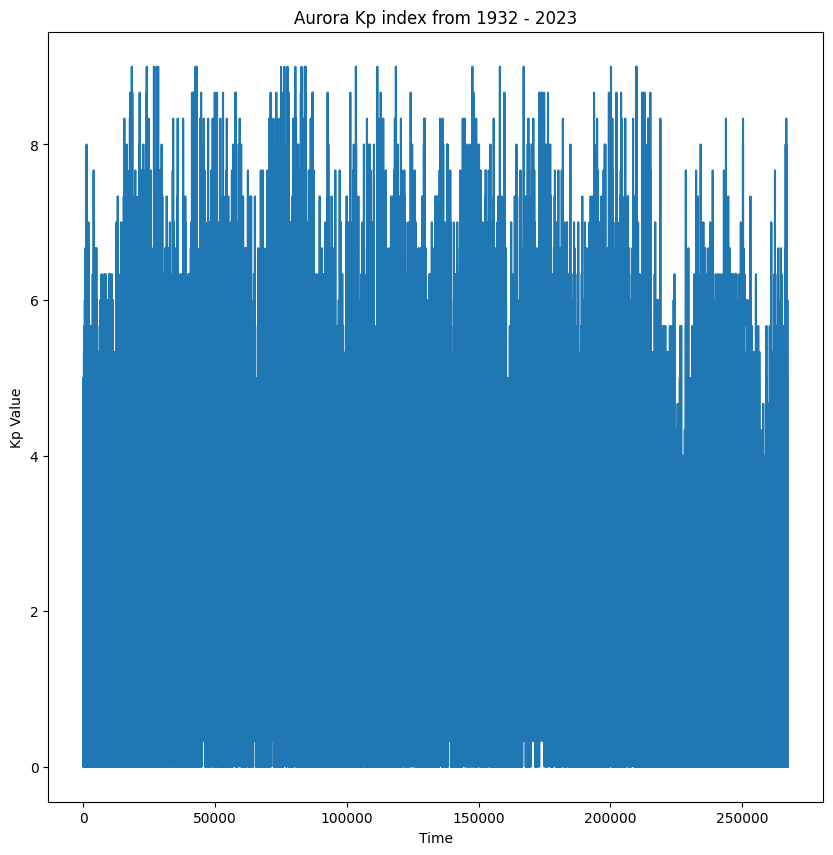

In [55]:
#Lets plot this to make sure its nice, 
#use this to determine how much data we actually might want to consider since this is 267,000 data points!
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_kp["Kp"])
plt.title("Aurora Kp index from 1932 - 2023")
plt.ylabel('Kp Value')
plt.xlabel('Time')
plt.show()

        #YYY  MM  DD  hh.h  hh._m     Kp  Unnamed: 6  Unnamed: 7  Unnamed: 8  \
257136  2020   1   1   0.0    1.5  0.333         NaN         NaN         NaN   
257137  2020   1   1   3.0    4.5  0.000         NaN         NaN         NaN   
257138  2020   1   1   6.0    7.5  0.000         NaN         NaN         NaN   
257139  2020   1   1   9.0   10.5  0.667         NaN         NaN         NaN   
257140  2020   1   1  12.0   13.5  0.667         NaN         NaN         NaN   
...      ...  ..  ..   ...    ...    ...         ...         ...         ...   
260059  2020  12  31   9.0   10.5  1.000         NaN         NaN         NaN   
260060  2020  12  31  12.0   13.5  0.667         NaN         NaN         NaN   
260061  2020  12  31  15.0   16.5  0.333         NaN         NaN         NaN   
260062  2020  12  31  18.0   19.5  0.000         NaN         NaN         NaN   
260063  2020  12  31  21.0   22.5  0.333         NaN         NaN         NaN   

        Unnamed: 9  Unnamed: 10  ap   D

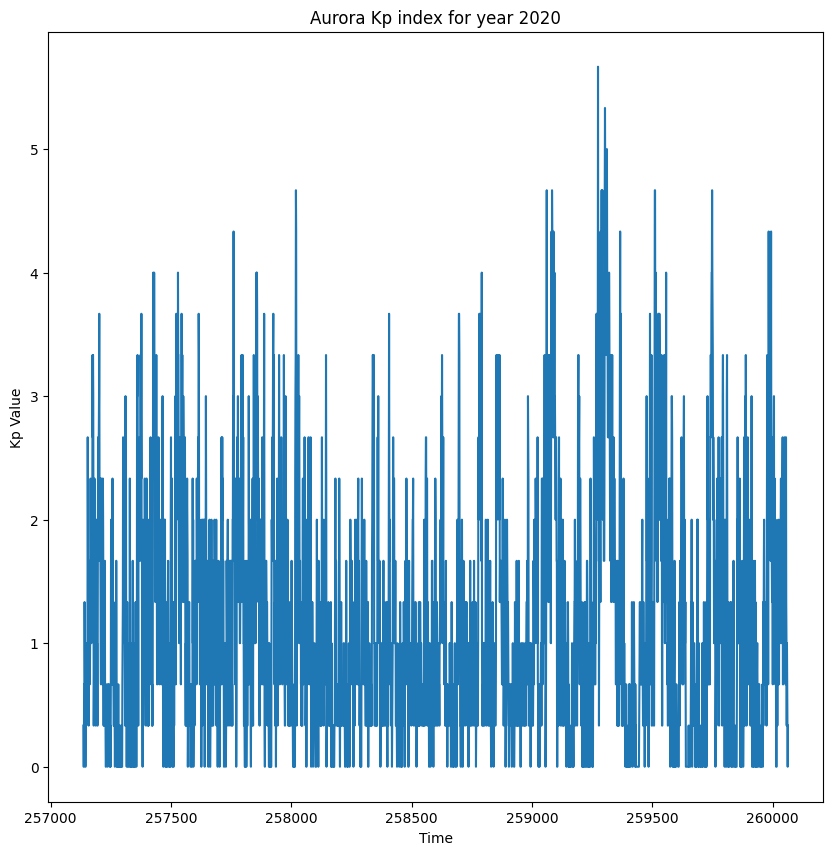

In [56]:
#this is waaay to dense to discern real data from, lets look at a year of data
#lets do this by cpoying the Kp values into a new dataframe if the Year for their data entry is 2020

df_2020 = df_kp[df_kp['#YYY'] == 2020]
print(df_2020)
#df_kp.loc["#YYY"]
#for entry in df_kp.index:
#    print(df_kp[entry])
    #if (entry["#YYY"] == 2020):
     #   dat2020.append(entry["Kp"])

plt.figure()
plt.plot(df_2020["Kp"])
plt.title("Aurora Kp index for year 2020")
plt.ylabel('Kp Value')
plt.xlabel('Time')
plt.show()

In [68]:
#Its time to split the training and test data 
#and scale them to properly train
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_col = ["Kp"]
df_train, df_test = train_test_split(df_kp, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_col].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_col])

kp = MinMaxScaler()
kp.fit_transform(np.reshape(df_train.loc[:, "Kp"].values, (-1, 1)))

Train and Test size 213945 53487


c:\Users\theja\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


array([[0.37033333],
       [0.29633333],
       [0.25922222],
       ...,
       [0.11111111],
       [0.037     ],
       [0.037     ]])

In [69]:
def build_timeseries(mat, y_col_index, TIME_STEPS, futuretime):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0-futuretime):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i+4, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat


In [70]:
#setup the time series
TIME_STEPS = 3
BATCH_SIZE = 32
x_t, y_t = build_timeseries(x_train, 0, TIME_STEPS,4)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 0, TIME_STEPS, 4)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (213942, 3, 1) (213942,)
length of time-series i/o (53484, 3, 1) (53484,)


Time to create the LSTM Model

In [71]:
# Import functions from Keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, 
                                            x_t.shape[2]), 
                                            dropout=0.0, 
                                            recurrent_dropout=0.0))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='linear'))
lstm_model.compile(loss='mean_squared_error', 
                   optimizer='sgd',
                   metrics=['mae'])

Time to Train!

Epoch 1/5
6685/6685 [==============================] - 18s 2ms/step - loss: 0.0222 - mae: 0.1178 - val_loss: 0.0166 - val_mae: 0.1072
Epoch 2/5
6685/6685 [==============================] - 17s 3ms/step - loss: 0.0204 - mae: 0.1118 - val_loss: 0.0163 - val_mae: 0.1057
Epoch 3/5
6685/6685 [==============================] - 16s 2ms/step - loss: 0.0204 - mae: 0.1115 - val_loss: 0.0161 - val_mae: 0.1046
Epoch 4/5
6685/6685 [==============================] - 16s 2ms/step - loss: 0.0203 - mae: 0.1114 - val_loss: 0.0169 - val_mae: 0.1081
Epoch 5/5
6685/6685 [==============================] - 16s 2ms/step - loss: 0.0203 - mae: 0.1114 - val_loss: 0.0161 - val_mae: 0.1046


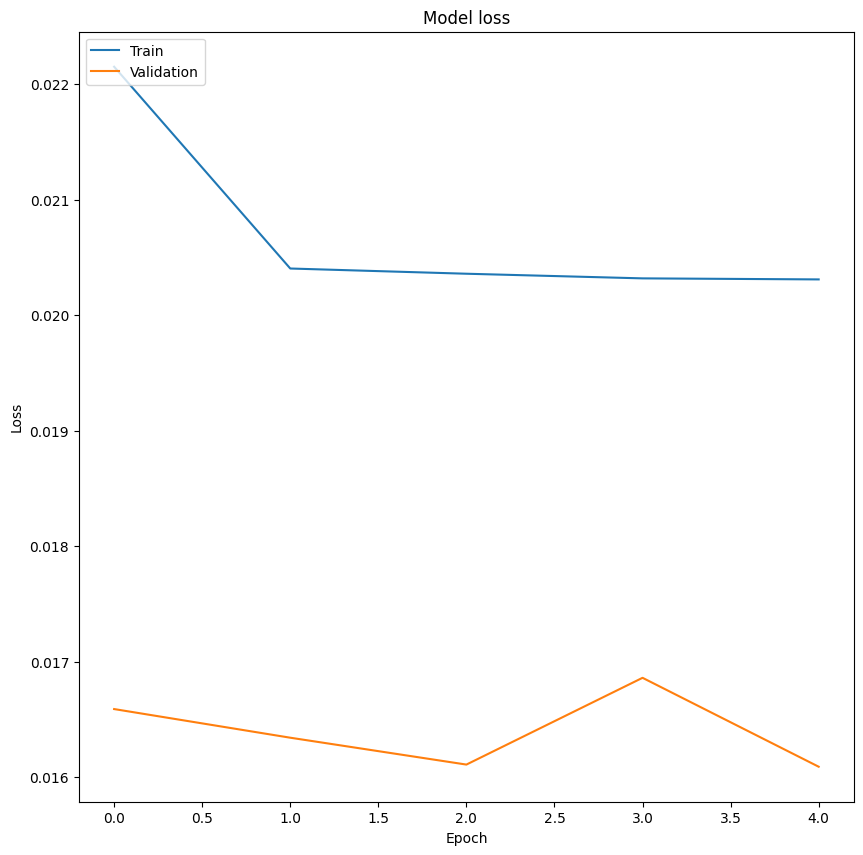

In [72]:
history = lstm_model.fit(x_t, y_t,
          batch_size=32, epochs=5, verbose=1,
          validation_data=(trim_dataset(x_val, BATCH_SIZE), 
                           trim_dataset(y_val, BATCH_SIZE)))

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

Performance Metrics:

In [73]:
score = lstm_model.evaluate(x_t, y_t, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1] )

6685/6685 [==============================] - 9s 1ms/step - loss: 0.0202 - mae: 0.1105
Test score: 0.020184053108096123
Test accuracy: 0.11049766093492508


Plotting Actual Vs. Predicted

In [74]:
predicted = lstm_model.predict(trim_dataset(x_val, BATCH_SIZE))
display(predicted)

835/835 [==============================] - 1s 1ms/step


array([[0.22777203],
       [0.2829951 ],
       [0.27090254],
       ...,
       [0.17398301],
       [0.16132402],
       [0.16079679]], dtype=float32)

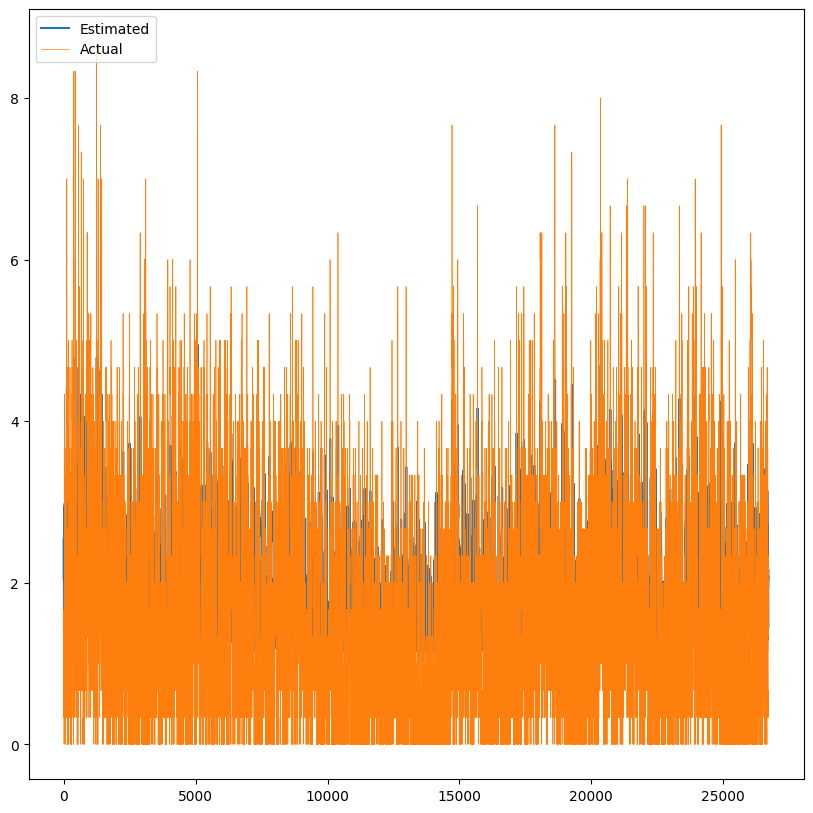

In [75]:
plt.figure()
plt.plot(kp.inverse_transform(predicted))
plt.plot(kp.inverse_transform(np.reshape(trim_dataset(y_val, BATCH_SIZE), (-1,1))), linewidth = 0.5)
plt.legend(['Estimated', 'Actual'], loc='upper left')

(22000.0, 22500.0)

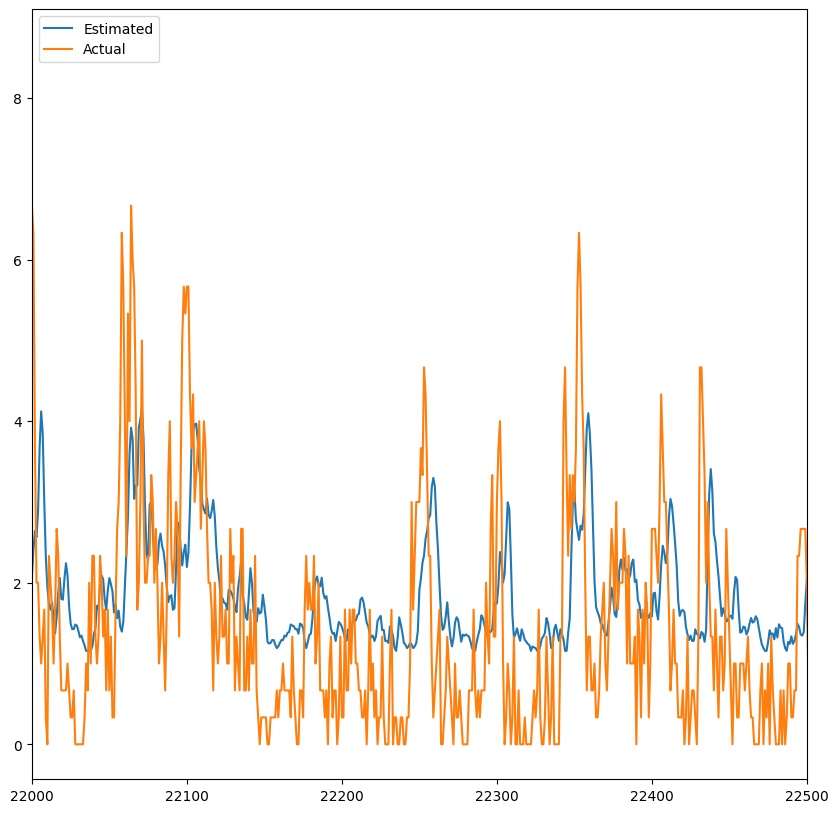

In [81]:
#theres a LOT of data points here, lets try to look at a few less 
plt.figure()
plt.plot(kp.inverse_transform(predicted))
plt.plot(kp.inverse_transform(np.reshape(trim_dataset(y_val, BATCH_SIZE), (-1,1))))
plt.legend(['Estimated', 'Actual'], loc='upper left')
plt.xlim([22000, 22500])